# Load python libraries

In [1]:
%matplotlib inline
import datetime
import math
import time
import sys
import unicodedata
import pandas as pd
import collections
import re
import glob
import os
import numpy as np
import json ## used for importing JSONs
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon ## for polygons
import PIL
from PIL import Image
Image.MAX_IMAGE_PIXELS = None # careful, this might get exploited

try:
    from StringIO import StringIO as sio
    from cStringIO import StringIO as csio
except ImportError:
    from io import StringIO as sio
    from io import BytesIO as csio
    
def removeDiacritics(string):
    """
    Removes diacritic marks from unicode.
    """
    return unicodedata.normalize('NFKD', string)

# 1. load all tiffs
# 2. extract tiff names and convert to numpy arrays
# 3. extract pixel information from arrays at x,y coordinates
def extractData(data,folder_path,prefix):
    """
    # creates a dictionary with variable names as keys and rasters as values
    # returns a dataframe with added columns, one per variable, with data from each variable rasters
    # make sure the main file name (variable) is not split by dots
    # bassically, works with the names as donwloaded from the CHELSA server
    # coordinate columns (lat, long) in dataframe need to be floats
    """
    var_raster_dict={}
    
    for filename in glob.glob(os.path.join(folder_path,'%s'%(prefix))):
        img=Image.open(filename)
        if '_1981-2010_V' in str(filename):
            variable=filename.split('/')[-1].split('.')[0].replace('_1981-2010_V','')
        else:
            variable=filename.split('/')[-1].split('.')[0]
        print('Processing %s'%(variable))
        img_arr = np.array(img) # from tif to numpy array
        raster_xll=img_arr.shape[1] # long size 20880, 43200
        raster_yll=img_arr.shape[0] # lat size
        
        raster_ycs=0.0083333333 # cell size, resolution declared by CHELSA technical specification
        raster_xcs=0.0083333333 # cell size, resolution declared by CHELSA technical specification

        cell=[]
        for xc,yc in zip(data['decimalLongitude'],data['decimalLatitude']):
            longs=(xc+180)/raster_xcs
            lats=(yc+90)/raster_ycs
            cell.append(img_arr[int(lats)][int(longs)])
        data['%s'%(variable)]=cell
    return data

# only if you already know that the code does not rise important errors but only warnings 
# and only if you checked the code DOES what you want it to do
pd.set_option('mode.chained_assignment',None)

# Preparing the data

----

This notebook prepares the GBIF data with records for Arecaceae (palms) and extracts all BioClim variables at each coordinate record. This notebook is a mix of python and R commands.

----


## 1. Cleaning records with coordinatecleaner in R

In [ ]:
%%bash
# after downloading the palm data from GBIF, we grep records that do not have 'fossil' on it
# the Global Biodiversity Information Facility - GBIF.org. 
# GBIF Occurrence Download  https://doi.org/10.15468/dl.w8djyx retrieved on april 2022
# the above retrieves 994,084 occurrences
grep -v 'fossil' ../data_files/GBIF_arecaceae_raw_20220425.csv > ../data_files/GBIF_arecaceae_raw_nofossil_20220425.csv

##### Before cleaning:

 714094 HUMAN_OBSERVATION  
   4797 LIVING_SPECIMEN  
   4797 MATERIAL_SAMPLE  
    542 OBSERVATION  
  10593 OCCURRENCE  
 259261 PRESERVED_SPECIMEN  
 
 
 ##### Only native cleaning:
 
   62890 HUMAN_OBSERVATION  
    322 LIVING_SPECIMEN  
    513 MATERIAL_SAMPLE  
     15 OBSERVATION  
   2073 OCCURRENCE  
  58890 PRESERVED_SPECIMEN  

In [ ]:
%load_ext rpy2.ipython # load jupyter notebook to run R kernels

In [ ]:
%%R

library(countrycode)
library(CoordinateCleaner)
library(dplyr)
library(ggplot2)
library(rgbif)
library(sp)

# we need to disable quoting to avoid errors ,sep="\t"
# 990484
gbif<-read.csv('../data_files/GBIF_arecaceae_raw_nofossil_20220425.csv',quote="",sep="\t", header=TRUE)

# we remove the rows with samples lacking coordinate information
# assuming longitud is empty if latitud is empty
nonan<-complete.cases(gbif$decimalLatitude)
# 858115
gbif1<-gbif[nonan,]

# clean out rows with empty country codes
nonan<-complete.cases(gbif1$countryCode)
# 857905
gbif2<-gbif1[nonan,]

#select columns of interest
# 857905
gbif2 <- gbif2 %>%
  dplyr::select(species, decimalLongitude, decimalLatitude, countryCode, individualCount,
                gbifID, family, taxonRank, coordinateUncertaintyInMeters, year,
                basisOfRecord, institutionCode)

# remove records without coordinates (second time)
# 857905
gbif2 <- gbif2%>%
  filter(!is.na(decimalLongitude))%>%
  filter(!is.na(decimalLatitude))

#plot data to get an overview
wm <- borders("world", colour="gray50", fill="gray50")
ggplot()+ coord_fixed()+ wm +
  geom_point(data = gbif2, aes(x = decimalLongitude, y = decimalLatitude),
             colour = "darkred", size = 0.5)+
  theme_bw()


#convert country code from ISO2c to ISO3c
gbif2$countryCode <-countrycode(gbif2$countryCode,origin ='iso2c',destination = 'iso3c')

# 0 rows
gbif2%>%filter(countryCode=='ZZ')


#flag problems
gbif2 <- data.frame(gbif2)
flags <- clean_coordinates(x = gbif2, 
                           lon = "decimalLongitude", 
                           lat = "decimalLatitude",
                           countries = "countryCode",
                           species = "species",
                           tests = c("capitals", "centroids", "equal","gbif", "institutions",
                                     "zeros", "countries"),
                           capitals_rad = 10000,
                           centroids_rad = 5000)

'''
Testing coordinate validity
Flagged 0 records.
Testing equal lat/lon
Flagged 2548 records.
Testing zero coordinates
Flagged 2722 records.
Testing country capitals
Flagged 4858 records.
Testing country centroids
Flagged 21720 records.
Testing country identity
Flagged 32997 records.
Testing GBIF headquarters, flagging records around Copenhagen
Flagged 0 records.
Testing biodiversity institutions
Flagged 813 records.
Flagged 52034 of 857905 records, EQ = 0.06.
'''

summary(flags)
'''
  .val     .equ     .zer     .cap     .cen     .con     .gbf    .inst .summary 
       0     2548     2722     4858    21720    32997        0      813    52034 
'''
plot(flags, lon = "decimalLongitude", lat = "decimalLatitude")

#The flagged records
gbif2_fl <- gbif2[!flags$.summary,]

plot(gbif2_fl, lon = "decimalLongitude", lat = "decimalLatitude")

## dealing with rows with the incorrect taxonomic rank
gbif2_fl%>%count(taxonRank)

'''
   taxonRank     n
1     FAMILY   374
2      GENUS  2055
3    SPECIES 48246
4 SUBSPECIES   615
5    VARIETY   744
'''

# versus the passed data
gbif2%>%count(taxonRank)
'''
   taxonRank      n
1     FAMILY   4468
2       FORM      3
3      GENUS  24736
4    SPECIES 708687
5 SUBSPECIES  19867
6    VARIETY 100144
'''

#Exclude problematic records
# 805871
gbif2_cl <- gbif2[flags$.summary,]

write.table(gbif2_cl, quote=F,sep="\t",file='../data_files/GBIF_arecaceae_cc_nofossil_20220425.csv')

## 2. Parsing Kew's worldwide species checklist

In [5]:
# Creating metadata dictionaries from parsing the Kew species list information
# file saved with UTF-8
# removed symbol *
kew_html_path='../data_files/Native_species_to_btocountries.html'
species_areas_dict={}
species_synon_dict={}
for line in open(kew_html_path,'r',encoding="utf8"):
    # detects the species count line and doesn't take it as species line (it is genus line)
    speciescountmatch=re.search('rptDetNameSpcCount',line)
    genuscountmatch=re.search('Arecaceae',line)
    # skips lines with irrelevant information
    if speciescountmatch or genuscountmatch:
        pass
    else:
        detnamematch=re.search('rptDetName',line)
        if detnamematch:
            # fetching information
            speciesmatch=re.search('<i><b>([A-Z][a-z]+)</b><b> ([a-z-]+)</b></i>',line) # note the space
            areamatch=re.search('"rptDetNameDescription">(.+?)</p>',line)
            synonmatch=re.findall('("rptDetNameSynonyms"> <i>[A-Z][a-z]+</i><i> [a-z-]+</i>.+</p>)',line)
            
            # asigning
            species='%s_%s'%(speciesmatch.group(1),speciesmatch.group(2)) if speciesmatch else None
            species_areas_dict[species]=re.findall('([A-Z][A-Z][A-Z])+',areamatch.group(0)) if areamatch else None
            
            synonyms=re.findall('([A-Z][a-z]+</i><i> [a-z-]+)</i> ',line)# if synonmatch else None
            species_synon_dict[species]=[x.replace('</i><i> ','_') for x in synonyms] if synonmatch else 'none'
# print(species_areas_dict)
# print(species_synon_dict)
data=pd.DataFrame()
# # print(list(species_areas_dict))
data['species']=list(species_areas_dict.keys())
data['areas']=data['species'].map(species_areas_dict)
data['synonyms']=data['species'].map(species_synon_dict)
data
data.to_csv('../data_files/Arecaceae_countries_synonyms_20220427.csv')

## 3. Dealing with species synonyms and standardizing the species field

It is necessary to deal with synonyms before annotating and estimating medians.


1. Identify species with synonyms. Change the 'species' field to accepted species name (Kew).  
2. Keep a variable tracing the old names  
3. Annotate the database with Chelsa variables  
4. Reduce the database to species medians (group by)  
5. Add column with old name  
6. Add column with synonyms  
7. Add column with name in Faurby's phylogeny.  

**detecting records in GBIF for synonym species that can be more than one accepted species should be removed: it is uncertain which variable values would those records have and that increases the noise.**

In [6]:
# loading the gbif data cleaned with coordinate cleaner
# the following removes species coordinates outside species native botanical countries

gbif=pd.read_csv('../data_files/GBIF_arecaceae_cc_nofossil_20220425.csv',sep='\t')
gbif
gbif['species']=gbif['species'].replace(' ','_',regex=True)
gbif['decimalLatitude']=gbif['decimalLatitude'].replace(',','.',regex=True)
gbif['decimalLongitude']=gbif['decimalLongitude'].replace(',','.',regex=True)
gbif.columns

Index(['species', 'decimalLongitude', 'decimalLatitude', 'countryCode',
       'individualCount', 'gbifID', 'family', 'taxonRank',
       'coordinateUncertaintyInMeters', 'year', 'basisOfRecord',
       'institutionCode'],
      dtype='object')

In [7]:
# for synonyms in GBIF (coded as synonyms in Kew)
# may be more efficient to first filter gbif records who's species field matches a synonym. Then do the testing.

syn_names=[]
withsyn=data[data['synonyms']!='none'] # only 635 species have synonyms
for x in withsyn['synonyms']:
    for xx in x:
        syn_names.append(xx)
# repeated synonym names: check if the repeated ones are now different accepted species. If so, this will cause problems: which variable values to map?
syn_names_uniq=list(set(syn_names))
count_syn=collections.Counter(syn_names)
syn_repeated=[key for key,values in count_syn.items() if values>1]

for spp in syn_repeated:
    print(spp,withsyn[withsyn['synonyms'].apply(lambda x: spp in x)]['species'].values)

Calamus_verschaffeltii ['Acanthophoenix_rubra']
Acoelorraphe_wrightii ['Acoelorraphe_wrightii']
Acrocomia_sclerocarpa ['Acrocomia_aculeata']
Bactris_minor ['Acrocomia_aculeata' 'Bactris_guineensis']
Acanthococos_emensis ['Acrocomia_emensis']
Martinezia_ulei ['Aiphanes_horrida' 'Aiphanes_ulei']
Diplothemium_campestre ['Allagoptera_campestris' 'Allagoptera_leucocalyx']
Archontophoenix_alexandrae ['Archontophoenix_alexandrae']
Seaforthia_elegans ['Archontophoenix_cunninghamiana' 'Ptychosperma_elegans']
Didymosperma_caudatum ['Arenga_caudata']
Erythea_brandegeei ['Brahea_brandegeei']
Brahea_dulcis ['Brahea_dulcis' 'Washingtonia_filifera']
Cyphosperma_vieillardii ['Burretiokentia_vieillardii']
Butia_capitata ['Butia_capitata' 'Butia_odorata' 'Butia_yatay']
Cocos_leiospatha ['Butia_capitata']
Cocos_elegantissima ['Butia_odorata' 'Syagrus_weddelliana']
Butia_yatay ['Butia_paraguayensis']
Daemonorops_fissa ['Calamus_fissus']
Daemonorops_hystrix ['Calamus_hirsutus']
Daemonorops_melanochaetes ['

In [8]:
to_delete=['Bactris_minor','Martinezia_ulei','Diplothemium_campestre','Seaforthia_elegans','Brahea_dulcis','Butia_capitata','Cocos_elegantissima','Coccothrinax_miraguama','Coccothrinax_yuraguana','Rhopaloblaste_micrantha','Dypsis_humbertii','Chrysalidocarpus_baronii','Nengella_calophylla','Livistona_chinensis','Mauritia_aculeata','Areca_oriziformis','Chamaerops_excelsa','Roystonea_regia','Oreodoxa_regia','Sabal_serrulata','Cocos_botryophora','Arecastrum_romanzoffianum','Cocos_acaulis','Cocos_flexuosa','Cocos_plumosa','Syagrus_petraea','Cocos_petraea']

gbif2=gbif[~gbif.species.isin(to_delete)]
# ambiguous accepted species:
# if a synonym is resolved to two different species or an accepted species has multiple synonyms
print('gbif total records including ambiguous accepted species: %s'%(len(gbif)))
print('gbif total records after removing those with ambiguous accepted species: %s'%(len(gbif2)))
print('records removed: ',(len(gbif)-len(gbif2)))


gbif total records including ambiguous accepted species: 805871
gbif total records after removing those with ambiguous accepted species: 803974
records removed:  1897


In [9]:
print(gbif2['species'].unique(),'\n')
print('Number of unique species in data after removing ambiguities: ',len(gbif2['species'].unique()))

['Oenocarpus_bataua' 'Manicaria_saccifera' 'Bactris_barronis' ...
 'Loxococcus_rupicola' 'Metroxylon_paulcoxii' 'Areca_mogeana'] 

Number of unique species in data after removing ambiguities:  2183


In [10]:
# standardizing the species field by changing the 'species' field. Then filtering out by country.
# Then reducing to medians and only then adding the synonym field.
# this is so processing time is lower and to not overcharge memory. 

# create a backup of the species column
gbif2_sppbkp=gbif2.loc[:,'species'].copy()
gbif2_sppbkp

# dictionary of synonyms to accepted species:
syn_spp_dict={}
for index,row in withsyn.iterrows():
    for x in row['synonyms']:
        syn_spp_dict[x]=row['species']

# with synonyms changed to accepted species
for index,row in gbif2.iterrows():
    if row['species'] in syn_names:
        gbif2.loc[index,'species']=syn_spp_dict[row['species']]
        
print('Unique species: ',gbif2['species'].unique(),'\n')
print('Number of unique species: ',len(gbif2['species'].unique()))

Unique species:  ['Oenocarpus_bataua' 'Manicaria_saccifera' 'Bactris_barronis' ...
 'Loxococcus_rupicola' 'Metroxylon_paulcoxii' 'Areca_mogeana'] 

Number of unique species:  2142


In [11]:
# sanity check
# Butia capitata is a synonym, not accepted name and the filter should result in zero columns
print(gbif2[gbif2['species']=='Butia_capitata'])
print(len(gbif))
print(len(gbif2))
gbif2.to_csv('../data_files/GBIF_arecaceae_cc_nofossil_renamed_tmp_20220425.csv',sep='\t')

Empty DataFrame
Columns: [species, decimalLongitude, decimalLatitude, countryCode, individualCount, gbifID, family, taxonRank, coordinateUncertaintyInMeters, year, basisOfRecord, institutionCode]
Index: []
805871
803974


## 4. Removing species records outside their native botanical country

In [12]:
json_path='../data_files/level3.geojson'
json_map=json.load(open(json_path,'r'))

In [13]:
features=json_map['features']
location_points={} ## location points will be stored here
polygons={} ## polygons will be stored here

locName='LEVEL3_COD' ## key name for each feature
for loc in features: ## iterate through features (locations)
    poly = np.asarray(loc['geometry']['coordinates']) ## get coordinates
    location=removeDiacritics(loc['properties'][locName]) ## standardised location name (remove diacritics)
    polygons[location]=[]
    location_points[location]=[]
    if loc['geometry']['type']=='MultiPolygon': ## multiple parts detected
        for part in np.asarray(poly): ## iterate over each component polygon
            for coords in np.asarray(part): ## iterate over coordinates
                coords=np.array(coords)
                xs=coords[:,0] ## longitudes
                ys=coords[:,1] ## latitudes
                location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
    if loc['geometry']['type']=='Polygon': ## location is single part
        for coords in np.asarray(poly): ## iterate over coordinates
            coords=np.array(coords)
            xs=coords[:,0] ## longitudes
            ys=coords[:,1] ## latitudes
            location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
    complete_location=[]
    for part in location_points[location]: ## iterate over each component of a location
        complete_location.append(Polygon(part,True)) ## create a polygon for each component of a location
    polygons[location]=complete_location ## assign list of polygons to a location

print(polygons['CLM'])
print('polygons loaded:\n%s'%(polygons.keys()))


<ipython-input-13-b8f4d0bb7f28>:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
/home/mftorres27/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<ipython-input-13-b8f4d0bb7f28>:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in

[<matplotlib.patches.Polygon object at 0x7ffd36caef10>, <matplotlib.patches.Polygon object at 0x7ffd36caefd0>, <matplotlib.patches.Polygon object at 0x7ffd36cb90d0>, <matplotlib.patches.Polygon object at 0x7ffd36cb9190>, <matplotlib.patches.Polygon object at 0x7ffd36cb9250>, <matplotlib.patches.Polygon object at 0x7ffd36cb9310>, <matplotlib.patches.Polygon object at 0x7ffd36cb93d0>, <matplotlib.patches.Polygon object at 0x7ffd36cb9490>, <matplotlib.patches.Polygon object at 0x7ffd36cb9550>]
polygons loaded:
dict_keys(['ABT', 'AFG', 'AGE', 'AGS', 'AGW', 'ALA', 'ALB', 'ALD', 'ALG', 'ALT', 'ALU', 'AMU', 'AND', 'ANG', 'ANT', 'ARI', 'ARK', 'ARU', 'ASC', 'ASK', 'ASP', 'ASS', 'ATP', 'AUT', 'AZO', 'BAH', 'BAL', 'BAN', 'BEN', 'BER', 'BGM', 'BIS', 'BKN', 'BLR', 'BLT', 'BLZ', 'BOL', 'BOR', 'BOT', 'BOU', 'BRC', 'BRY', 'BUL', 'BUR', 'BZC', 'BZE', 'BZL', 'BZN', 'BZS', 'CAB', 'CAF', 'CAL', 'CAY', 'CBD', 'CGS', 'CHA', 'CHC', 'CHH', 'CHI', 'CHM', 'CHN', 'CHQ', 'CHS', 'CHT', 'CHX', 'CKI', 'CLC', 'CLM', 

In [14]:
gbif2['decimalLatitude']=gbif2['decimalLatitude'].astype('float')
gbif2['decimalLongitude']=gbif2['decimalLongitude'].astype('float')

In [15]:
# removing entries with the exact same species and coordinates
# # before testing and cleaning for native country!!!! otherwise it takes ages for nothing
# gbif_onlynative_withdups=gbif_onlynative
# gbif_onlynative=gbif_onlynative_withdups.drop_duplicates(subset=['species','decimalLatitude','decimalLongitude'],keep='first')
# print(len(gbif_onlynative_withdups))
# print(len(gbif_onlynative))

gbif2_withdups=gbif2.copy(deep=True)
gbif2_withoutdups=gbif2_withdups.drop_duplicates(subset=['species','decimalLatitude','decimalLongitude'],keep='first')
print('Total records including duplicates: ',len(gbif2_withdups))
print('Total records excluding duplicates: ',len(gbif2_withoutdups))

Total records including duplicates:  803974
Total records excluding duplicates:  162652


In [16]:
# for Kew's accepted species names
gbif_onlynative=pd.DataFrame()
for index,row in gbif2_withoutdups.iterrows():  
#     # if species in the list with locations
    if row['species'] in data['species'].values:
        boollist=[]
        # gather the coordinates for that row
        testpoint=[row['decimalLongitude'],row['decimalLatitude']]
        # for country in the list of countries
        for country in data[data['species']==row['species']]['areas']:
            for con in country:
                if con in polygons.keys():
                    # call the polygons:
                    polys=polygons[con]
                    for p in polys:
                        boollist.append(p.contains_point(testpoint, radius=1e-9))
            if True in boollist:
                gbif_onlynative=gbif_onlynative.append(row[gbif2_withoutdups.columns],ignore_index=True) # ignoring index is optional


In [17]:
# mapping first species accepted by kew with records in gbif
print(len(gbif_onlynative))
print(len(gbif))
gbif_onlynative.to_csv('../data_files/GBIF_arecaceae_onlynative_20220425.csv',sep='\t')

124703
805871


## 5. Annotating Chelsa BioClim variables for all coordinate records

### Download Chelsa variables

Entire Directory Download of "chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/"

In [20]:
%%bash
while IFS='' read -r line; do 
    wget $line
done < ../data_files/envidatS3paths.txt

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
%%bash
mv *tif ../data_files/
echo '*tif' >> ../.gitignore

In [2]:
# removing exact coordinate duplicates for every species
# comes back to the number of rows before the second round of native-country cleaning. Need to fix the code above to make it non-redundant
gbif_onlynative=pd.read_csv('../data_files/GBIF_arecaceae_onlynative_20220425.csv',sep='\t')
print(len(gbif_onlynative))
# gbif_onlynative_nodup=gbif_onlynative.drop_duplicates(subset=['species','decimalLatitude','decimalLongitude'],keep='first')
# print(len(gbif_onlynative_nodup))

124703


In [3]:
print(len(gbif_onlynative['species'].unique())) # old 1785 new we have 1908

1908


In [4]:
gbif_chelsa=extractData(gbif_onlynative,'../data_files/','*tif')
gbif_chelsa

Processing CHELSA_ai
Processing CHELSA_bio10
Processing CHELSA_bio11
Processing CHELSA_bio12
Processing CHELSA_bio13
Processing CHELSA_bio14
Processing CHELSA_bio15
Processing CHELSA_bio16
Processing CHELSA_bio17
Processing CHELSA_bio18
Processing CHELSA_bio19
Processing CHELSA_bio1
Processing CHELSA_bio2
Processing CHELSA_bio3
Processing CHELSA_bio4
Processing CHELSA_bio5
Processing CHELSA_bio6
Processing CHELSA_bio7
Processing CHELSA_bio8
Processing CHELSA_bio9
Processing CHELSA_cmi_max
Processing CHELSA_cmi_mean
Processing CHELSA_cmi_min
Processing CHELSA_cmi_range
Processing CHELSA_fcf
Processing CHELSA_gdd0
Processing CHELSA_gdgfgd0
Processing CHELSA_gsl
Processing CHELSA_gst
Processing CHELSA_hurs_max
Processing CHELSA_hurs_min
Processing CHELSA_hurs_range
Processing CHELSA_lgd
Processing CHELSA_ngd0
Processing CHELSA_npp
Processing CHELSA_vpd_max
Processing CHELSA_vpd_mean
Processing CHELSA_vpd_min


,Unnamed: 0,basisOfRecord,coordinateUncertaintyInMeters,countryCode,decimalLatitude,decimalLongitude,family,gbifID,individualCount,institutionCode,...,CHELSA_gst,CHELSA_hurs_max,CHELSA_hurs_min,CHELSA_hurs_range,CHELSA_lgd,CHELSA_ngd0,CHELSA_npp,CHELSA_vpd_max,CHELSA_vpd_mean,CHELSA_vpd_min
0,0,HUMAN_OBSERVATION,NaN,COL,5.683333,-76.633333,Arecaceae,2.635070e+09,1.0,IIAP,...,2782,6689,4973,1716,0,365,9861,4455,3739,2869
1,1,HUMAN_OBSERVATION,NaN,COL,5.683333,-76.633333,Arecaceae,2.635070e+09,1.0,IIAP,...,2782,6689,4973,1716,0,365,9861,4455,3739,2869
2,2,HUMAN_OBSERVATION,NaN,COL,5.683333,-76.633333,Arecaceae,2.635070e+09,1.0,IIAP,...,2782,6689,4973,1716,0,365,9861,4455,3739,2869
3,3,HUMAN_OBSERVATION,NaN,COL,5.683333,-76.633333,Arecaceae,2.635070e+09,1.0,IIAP,...,2782,6689,4973,1716,0,365,9861,4455,3739,2869
4,4,HUMAN_OBSERVATION,NaN,COL,5.683333,-76.633333,Arecaceae,2.635070e+09,1.0,IIAP,...,2782,6689,4973,1716,0,365,9861,4455,3739,2869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124698,124698,HUMAN_OBSERVATION,NaN,BEN,10.883300,1.483300,Arecaceae,2.238631e+09,NaN,SOS Biodiversity,...,2936,6101,5833,268,26,365,3053,11371,9676,8089
124699,124699,HUMAN_OBSERVATION,NaN,BEN,9.750000,2.433300,Arecaceae,2.238625e+09,NaN,SOS Biodiversity,...,2939,6155,5888,267,24,365,2508,11494,9624,7915
124700,124700,HUMAN_OBSERVATION,NaN,BEN,10.900000,1.483300,Arecaceae,2.238630e+09,NaN,SOS Biodiversity,...,2937,6100,5832,268,26,365,3067,11373,9675,8090
124701,124701,HUMAN_OBSERVATION,NaN,BEN,10.816600,1.150000,Arecaceae,2.238631e+09,NaN,SOS Biodiversity,...,2938,6094,5817,277,27,365,3216,11413,9725,8161


shape:  (20880, 43200)
dtype:  uint16
min:  2196
max:  3079
max-min 883
min dividing by years 75.72413793103448


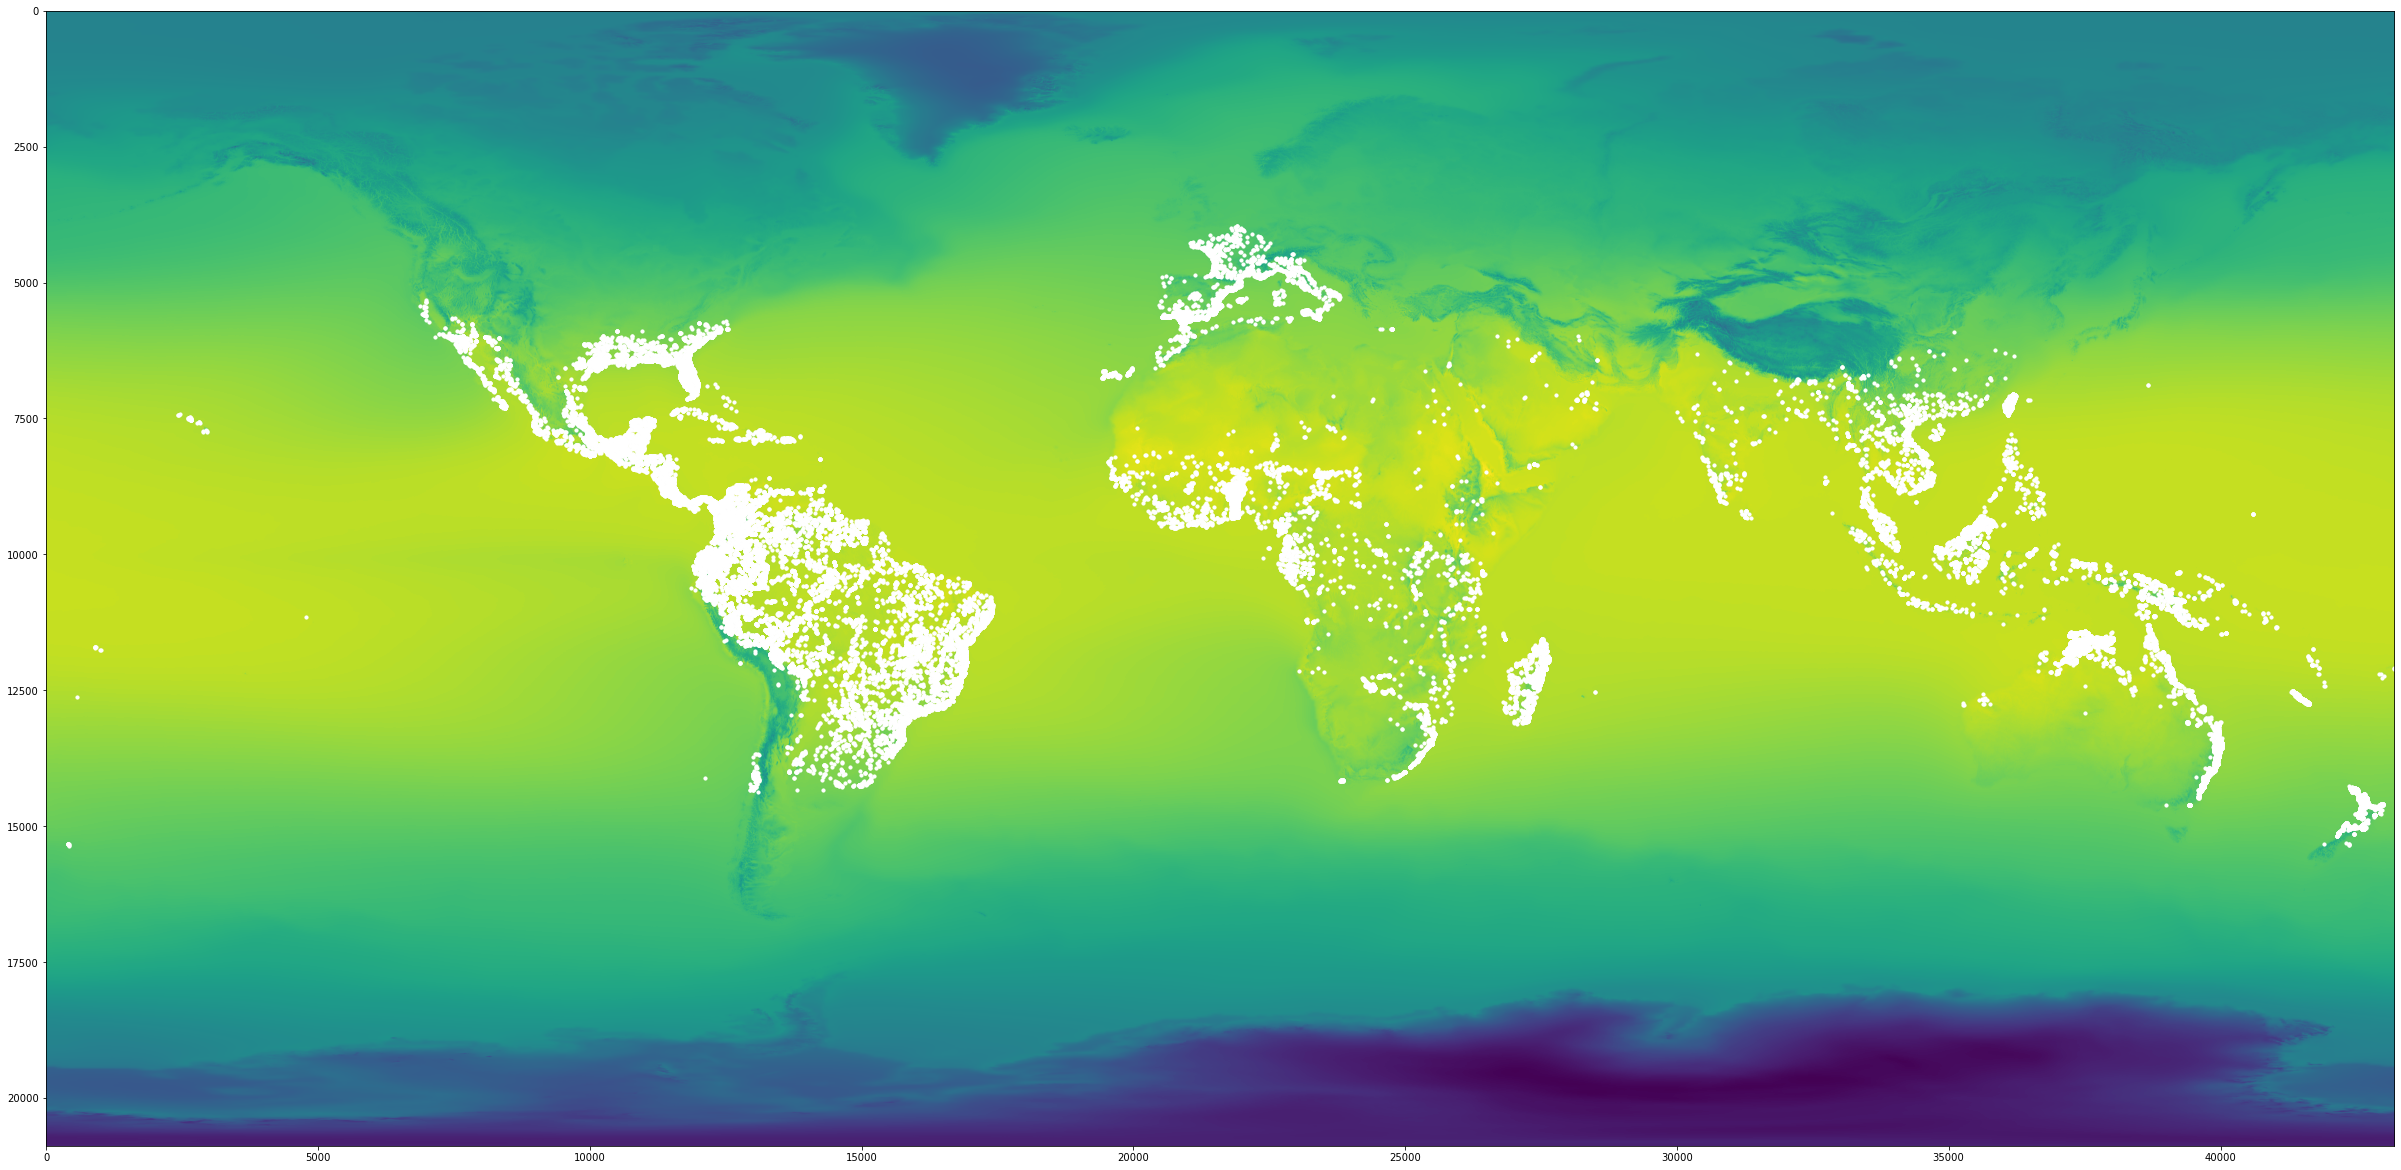

In [21]:
# example map with Bio4

img=Image.open('../data_files/CHELSA_bio1_1981-2010_V.2.1.tif')
# # img.show()
img_arr = np.array(img)

print('shape: ',img_arr.shape)
print('dtype: ',img_arr.dtype)
print('min: ',(np.amin(img_arr)))
print('max: ',(np.amax(img_arr)))
print('max-min',(np.amax(img_arr))-(np.amin(img_arr)))
print('min dividing by years',(np.amin(img_arr))/(2010-1981))

fig,ax=plt.subplots(figsize=(43200*0.001,20880*0.001))
ax.imshow(img_arr)
ax.set_ylim(20880,0)

raster_xll=43200 # long size 20880, 43200
raster_yll=20880 # lat size
raster_ycs=0.0083333333 # cell size, resolution declared by CHELSA technical specification
raster_xcs=0.0083333333 # cell size, resolution declared by CHELSA technical specification

tifLongs=[]
tifLats=[]
for xc,yc in zip(gbif_chelsa['decimalLongitude'],gbif_chelsa['decimalLatitude']):
    tifLongs.append((xc+180)/raster_xcs)
    tifLats.append(20880-((yc+90)/raster_ycs)) # 20880*coord is just FOR PLOTTING WITH IMG + MATPLOTLIB AX coordinates!
ax.scatter(tifLongs,tifLats,color='w',s=10)
plt.show()

Above, Bio1 has minimum value of 2196 and maximum of 3079. 

The difference is 883
according to the info shown in Qgis from the same tif, minimum is -53.55 and maximum is 34.75. The difference is 88.3.

The units should be temp in Celsius degrees divided by 10

CHELSA mentiones this variable has an offset of -273.15, so I need to substract 2731.5 from all values.

The same is the case for a lot of variables

https://chelsa-climate.org/wp-admin/download-page/CHELSA_tech_specification_V2.pdf

In [23]:
offset={'CHELSA_ai':0, # prec / (Mean Annual Potential Evapotranspiration)
        'CHELSA_bio10':2731.5, #0.1 scale
        'CHELSA_bio11':2731.5, #0.1 scale
        'CHELSA_bio12':0, #0.1 scale
       'CHELSA_bio13':0, #0.1 scale
        'CHELSA_bio14':0, #0.1 scale
        'CHELSA_bio15':0, #0.1 scale
        'CHELSA_bio16':0, #0.1 scale
       'CHELSA_bio17':0, #0.1 scale
        'CHELSA_bio18':0, #0.1 scale
        'CHELSA_bio19':0, #0.1 scale
        'CHELSA_bio1':2731.5, #0.1 scale
       'CHELSA_bio2':0,  #0.1 scale
        'CHELSA_bio3':0,  #0.1 scale
        'CHELSA_bio4':0,  #0.1 scale
        'CHELSA_bio5':2731.5,  #0.1 scale
       'CHELSA_bio6':2731.5,  #0.1 scale
        'CHELSA_bio7':0,  #0.1 scale
        'CHELSA_bio8':2731.5,  #0.1 scale
        'CHELSA_bio9':2731.5,  #0.1 scale
       'CHELSA_cmi_max':0,  #0.1 scale
        'CHELSA_cmi_mean':0,  #0.1 scale
        'CHELSA_cmi_min':0,  #0.1 scale
       'CHELSA_cmi_range':0,  #0.1 scale
        'CHELSA_fcf':0 , # count
        'CHELSA_gdd0':0,  #0.1 scale
        'CHELSA_gdgfgd0':0,  #day
       'CHELSA_gsl':0,  #day
        'CHELSA_gst':2731.5, #0.1 scale
        'CHELSA_hurs_max':0,  #0.01 percentage
        'CHELSA_hurs_min':0,  #0.01 percentage
       'CHELSA_hurs_range':0,  #0.01 percentage
        'CHELSA_lgd':0,  #day
        'CHELSA_ngd0':0,  #day
        'CHELSA_npp':0,  #0.1 scale
       'CHELSA_vpd_max':0,  #0.1 scale
        'CHELSA_vpd_mean':0,  #0.1 scale
        'CHELSA_vpd_min':0}  #0.1 scale
        

In [24]:
gbif_chelsa_backup=gbif_chelsa.copy(deep=True)
for key,value in offset.items():
    gbif_chelsa['%s'%(key)]=gbif_chelsa['%s'%(key)]-value
    
gbif_chelsa[list(offset.keys())].describe()

,CHELSA_ai,CHELSA_bio10,CHELSA_bio11,CHELSA_bio12,CHELSA_bio13,CHELSA_bio14,CHELSA_bio15,CHELSA_bio16,CHELSA_bio17,CHELSA_bio18,...,CHELSA_gst,CHELSA_hurs_max,CHELSA_hurs_min,CHELSA_hurs_range,CHELSA_lgd,CHELSA_ngd0,CHELSA_npp,CHELSA_vpd_max,CHELSA_vpd_mean,CHELSA_vpd_min
count,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,...,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000
mean,-66005.212287,227.023388,190.715440,15465.706382,2086.317963,630.793854,418.523412,5730.490237,2178.051859,3802.876434,...,620.392096,6526.925824,5954.925351,572.000473,15.921133,364.410295,14605.342630,11377.152963,9756.628397,8420.864278
std,47369.199502,60.479938,64.584829,11527.766041,1455.051464,655.804105,258.247149,4048.895223,2166.437702,2982.609748,...,5059.487118,539.995533,604.733061,470.641103,45.445989,9.802598,8364.226301,4374.967839,3273.935198,2781.124699
min,-99999.000000,4.500000,-75.500000,5.000000,1.000000,0.000000,61.000000,3.000000,0.000000,0.000000,...,9.500000,4164.000000,2752.000000,69.000000,0.000000,107.000000,10.000000,2109.000000,1763.000000,552.000000
25%,-99999.000000,212.500000,160.500000,3900.000000,641.000000,96.000000,210.000000,1736.500000,378.000000,850.000000,...,184.500000,6110.000000,5715.000000,232.000000,0.000000,365.000000,6535.000000,9476.000000,8144.000000,6635.000000
50%,-99999.000000,250.500000,191.500000,13518.000000,2072.000000,399.000000,337.000000,5593.000000,1418.000000,3669.000000,...,224.500000,6488.000000,5902.000000,422.000000,0.000000,365.000000,15850.000000,11456.000000,9795.000000,8474.000000
75%,1.220145,268.500000,245.500000,23610.000000,3178.000000,965.500000,562.000000,8895.000000,3265.000000,5796.500000,...,255.500000,6950.000000,6338.000000,772.000000,18.000000,365.000000,22052.000000,13052.000000,12295.000000,10498.500000
max,6.947495,354.500000,287.500000,65535.000000,12684.000000,4535.000000,2057.000000,34783.000000,14768.000000,20603.000000,...,62803.500000,9729.000000,8294.000000,3848.000000,363.000000,365.000000,26150.000000,41199.000000,27321.000000,19486.000000


In [25]:
print(gbif_chelsa.columns)
gbif_chelsa.to_csv('../data_files/GBIF_arecaceae_chelsa_20220502.csv',sep='\t')

Index(['Unnamed: 0', 'basisOfRecord', 'coordinateUncertaintyInMeters',
       'countryCode', 'decimalLatitude', 'decimalLongitude', 'family',
       'gbifID', 'individualCount', 'institutionCode', 'species', 'taxonRank',
       'year', 'CHELSA_ai', 'CHELSA_bio10', 'CHELSA_bio11', 'CHELSA_bio12',
       'CHELSA_bio13', 'CHELSA_bio14', 'CHELSA_bio15', 'CHELSA_bio16',
       'CHELSA_bio17', 'CHELSA_bio18', 'CHELSA_bio19', 'CHELSA_bio1',
       'CHELSA_bio2', 'CHELSA_bio3', 'CHELSA_bio4', 'CHELSA_bio5',
       'CHELSA_bio6', 'CHELSA_bio7', 'CHELSA_bio8', 'CHELSA_bio9',
       'CHELSA_cmi_max', 'CHELSA_cmi_mean', 'CHELSA_cmi_min',
       'CHELSA_cmi_range', 'CHELSA_fcf', 'CHELSA_gdd0', 'CHELSA_gdgfgd0',
       'CHELSA_gsl', 'CHELSA_gst', 'CHELSA_hurs_max', 'CHELSA_hurs_min',
       'CHELSA_hurs_range', 'CHELSA_lgd', 'CHELSA_ngd0', 'CHELSA_npp',
       'CHELSA_vpd_max', 'CHELSA_vpd_mean', 'CHELSA_vpd_min'],
      dtype='object')


Lat:  3513.297049503759 Long:  24639.151364960413
Lat:  16646.70286409624 Long:  18560.848807839586


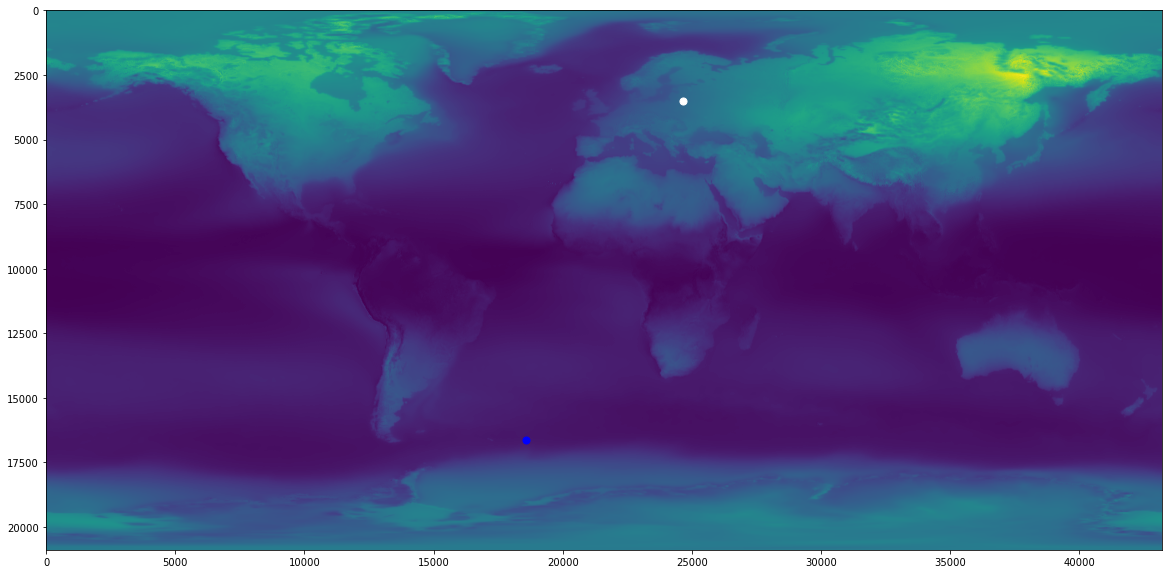

In [17]:
# example map with Bio4

img=Image.open('../data_files/CHELSA_bio4_1981-2010_V.2.1.tif')
# # img.show()
img_arr = np.array(img)


fig,ax=plt.subplots(figsize=(20,10))
ax.imshow(img_arr)

VUy=54.72252400857858
VUx=25.32626055336507
raster_ycs=0.0083333333 # cell size, resolution declared by CHELSA technical specification
raster_xcs=0.0083333333

VULongs=(VUx+180)/raster_xcs
VULats=20880-((VUy+90)/raster_ycs)
print('Lat: ',VULats,'Long: ',VULongs)

nVUy=-54.72252400857858
nVUx=-25.32626055336507

nVULongs=(nVUx+180)/raster_xcs
nVULats=20880-((nVUy+90)/raster_ycs)
print('Lat: ',nVULats,'Long: ',nVULongs)

# plots work.
ax.scatter(VULongs,VULats,s=50,color='w')
ax.scatter(nVULongs,nVULats,s=50,color='b')

plt.show()

In [2]:
# back to python
bioenv_extract=pd.read_csv('../data_files/GBIF_arecaceae_chelsa_20220502.csv',sep='\t')
bioenv_extract.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

chelsa_cols=['CHELSA_ai', 'CHELSA_bio10', 'CHELSA_bio11', 'CHELSA_bio12',
       'CHELSA_bio13', 'CHELSA_bio14', 'CHELSA_bio15', 'CHELSA_bio16',
       'CHELSA_bio17', 'CHELSA_bio18', 'CHELSA_bio19', 'CHELSA_bio1',
       'CHELSA_bio2', 'CHELSA_bio3', 'CHELSA_bio4', 'CHELSA_bio5',
       'CHELSA_bio6', 'CHELSA_bio7', 'CHELSA_bio8', 'CHELSA_bio9',
       'CHELSA_cmi_max', 'CHELSA_cmi_mean', 'CHELSA_cmi_min',
       'CHELSA_cmi_range', 'CHELSA_fcf', 'CHELSA_gdd0', 'CHELSA_gdgfgd0',
       'CHELSA_gsl', 'CHELSA_gst', 'CHELSA_hurs_max', 'CHELSA_hurs_min',
       'CHELSA_hurs_range', 'CHELSA_lgd', 'CHELSA_ngd0', 'CHELSA_npp',
       'CHELSA_vpd_max', 'CHELSA_vpd_mean', 'CHELSA_vpd_min']
bioenv_extract[chelsa_cols].describe()

,CHELSA_ai,CHELSA_bio10,CHELSA_bio11,CHELSA_bio12,CHELSA_bio13,CHELSA_bio14,CHELSA_bio15,CHELSA_bio16,CHELSA_bio17,CHELSA_bio18,...,CHELSA_gst,CHELSA_hurs_max,CHELSA_hurs_min,CHELSA_hurs_range,CHELSA_lgd,CHELSA_ngd0,CHELSA_npp,CHELSA_vpd_max,CHELSA_vpd_mean,CHELSA_vpd_min
count,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,...,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000,124703.000000
mean,-66005.212287,227.023388,190.715440,15465.706382,2086.317963,630.793854,418.523412,5730.490237,2178.051859,3802.876434,...,620.392096,6526.925824,5954.925351,572.000473,15.921133,364.410295,14605.342630,11377.152963,9756.628397,8420.864278
std,47369.199502,60.479938,64.584829,11527.766041,1455.051464,655.804105,258.247149,4048.895223,2166.437702,2982.609748,...,5059.487118,539.995533,604.733061,470.641103,45.445989,9.802598,8364.226301,4374.967839,3273.935198,2781.124699
min,-99999.000000,4.500000,-75.500000,5.000000,1.000000,0.000000,61.000000,3.000000,0.000000,0.000000,...,9.500000,4164.000000,2752.000000,69.000000,0.000000,107.000000,10.000000,2109.000000,1763.000000,552.000000
25%,-99999.000000,212.500000,160.500000,3900.000000,641.000000,96.000000,210.000000,1736.500000,378.000000,850.000000,...,184.500000,6110.000000,5715.000000,232.000000,0.000000,365.000000,6535.000000,9476.000000,8144.000000,6635.000000
50%,-99999.000000,250.500000,191.500000,13518.000000,2072.000000,399.000000,337.000000,5593.000000,1418.000000,3669.000000,...,224.500000,6488.000000,5902.000000,422.000000,0.000000,365.000000,15850.000000,11456.000000,9795.000000,8474.000000
75%,1.220145,268.500000,245.500000,23610.000000,3178.000000,965.500000,562.000000,8895.000000,3265.000000,5796.500000,...,255.500000,6950.000000,6338.000000,772.000000,18.000000,365.000000,22052.000000,13052.000000,12295.000000,10498.500000
max,6.947495,354.500000,287.500000,65535.000000,12684.000000,4535.000000,2057.000000,34783.000000,14768.000000,20603.000000,...,62803.500000,9729.000000,8294.000000,3848.000000,363.000000,365.000000,26150.000000,41199.000000,27321.000000,19486.000000


## 6. Annotating forest height

<!-- For later, tiffs are too big and in tiles.

Downloaded continental tif files from https://glad.umd.edu/dataset/gedi/

The citation should be:
P. Potapov, X. Li, A. Hernandez-Serna, A. Tyukavina, M.C. Hansen, A. Kommareddy, A. Pickens, S. Turubanova, H. Tang, C.E. Silva, J. Armston, R. Dubayah, J. B. Blair, M. Hofton (2020) Mapping and monitoring global forest canopy height through integration of GEDI and Landsat data. Remote Sensing of Environment, 112165. https://doi.org/10.1016/j.rse.2020.112165

Tif files were merged in QGIS 3.16.8 -->

Simard, Pinto, 3D Global Vegetation Height

shape:  (21600, 43200)
dtype:  uint8
min:  0
max:  73
max-min 73


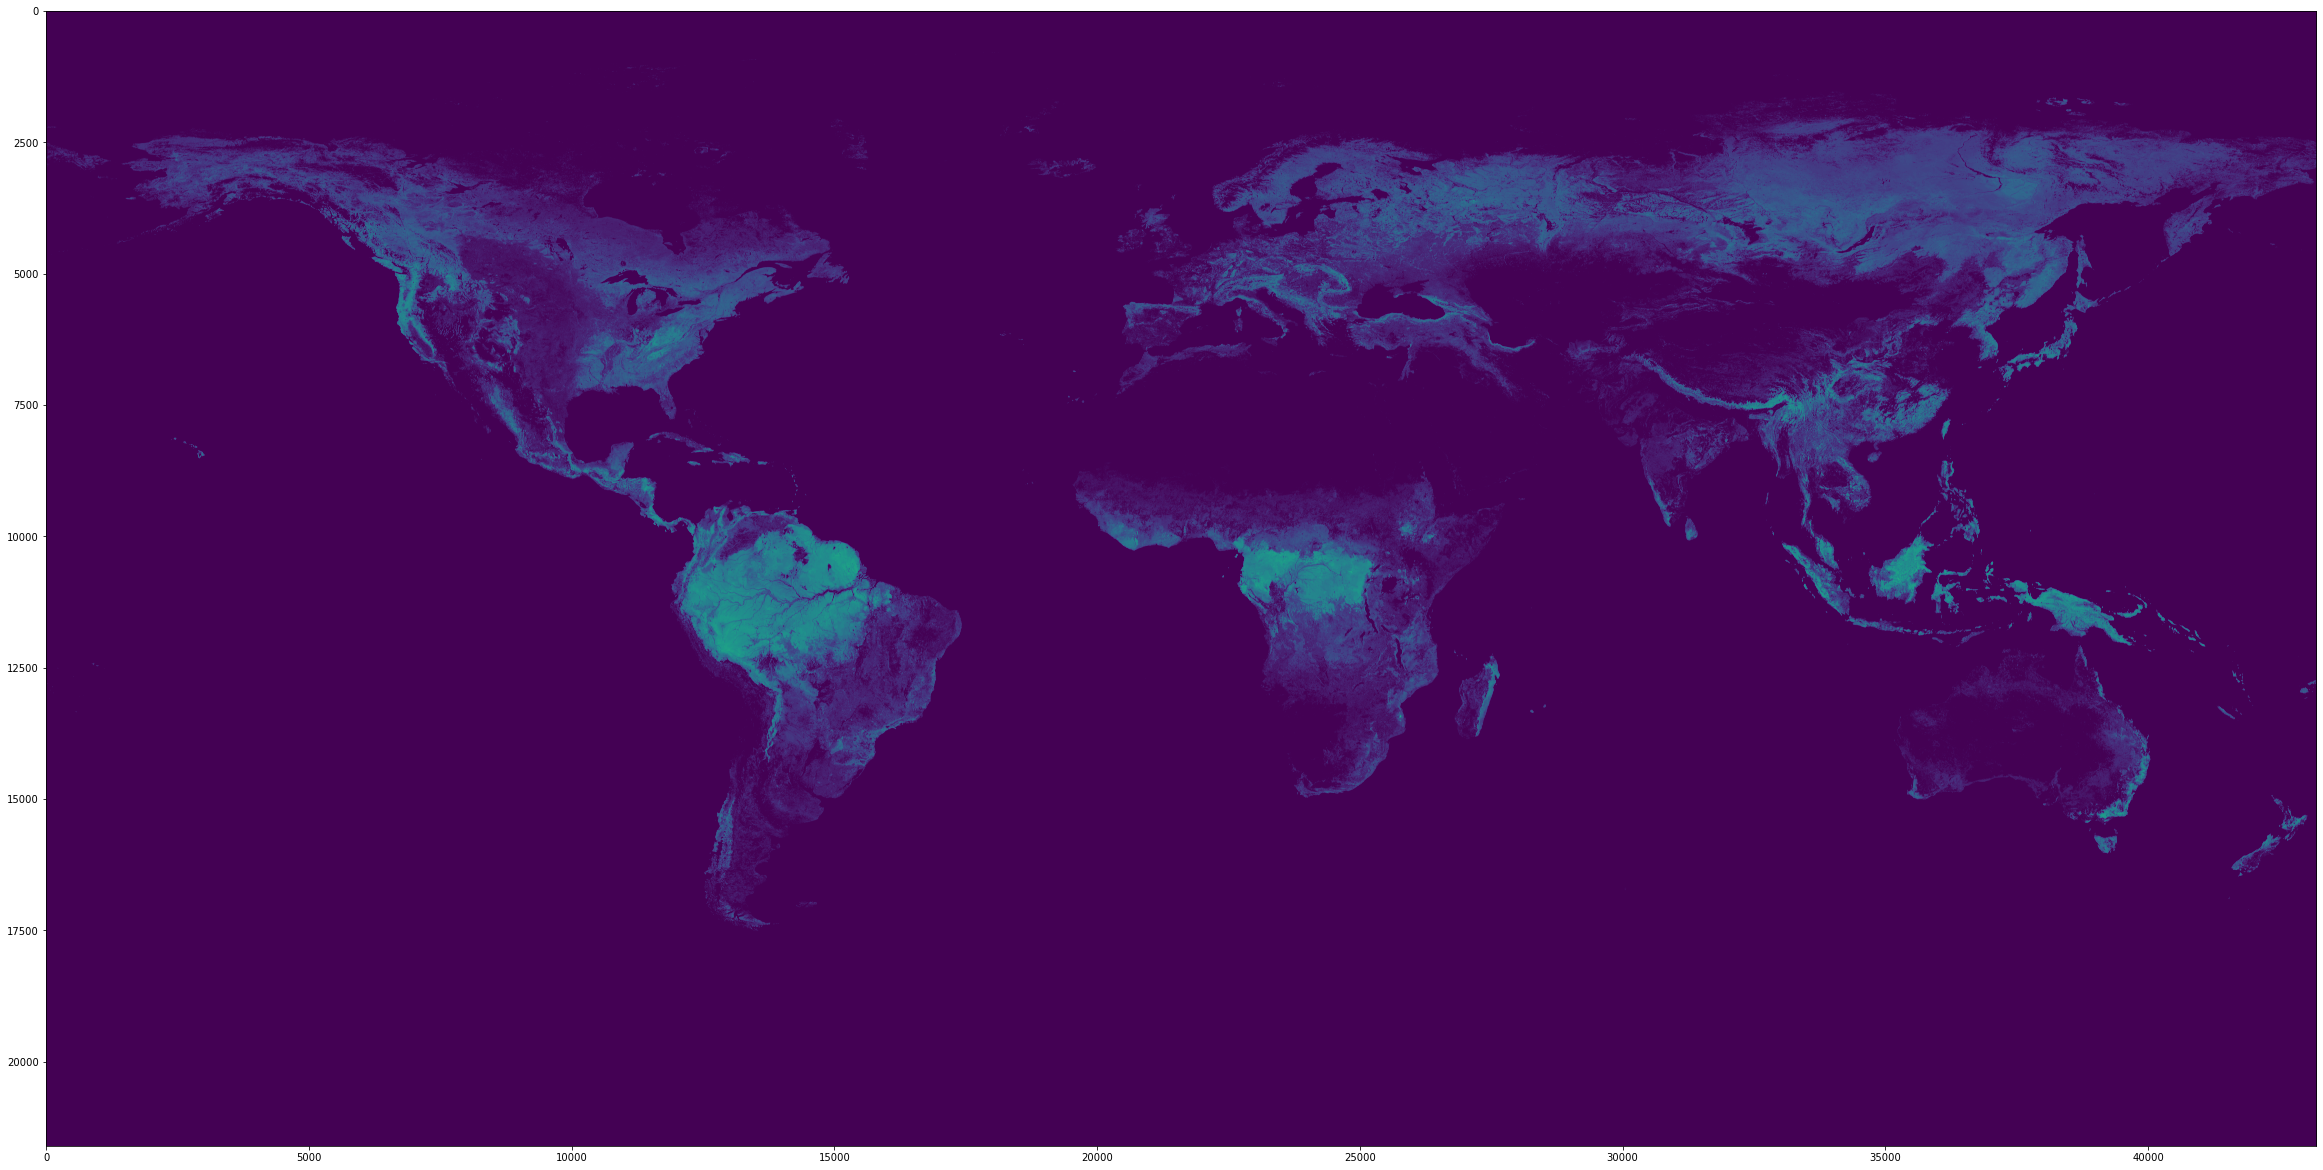

In [3]:
# loading tiles
# example map with Bio4

# this layer has as no_data value nans, which means during processing, nans will turn any operational result into nans and I 
# dont need to take care of it (unlike other rasters with a no_data default value set as an integer)
img=Image.open('../data_files/Simard_Pinto_3DGlobalVeg_JGR.tif')
# # img.show()
img_arr = np.array(img)

print('shape: ',img_arr.shape)
print('dtype: ',img_arr.dtype)
print('min: ',(np.amin(img_arr)))
print('max: ',(np.amax(img_arr)))
print('max-min',(np.amax(img_arr))-(np.amin(img_arr)))

fig,ax=plt.subplots(figsize=(43200*0.001,20880*0.001))
ax.imshow(img_arr)

plt.show()

In [5]:
bioenv_extract_fh=extractData(bioenv_extract,'../data_files/','*JGR.tif')
bioenv_extract_fh

Processing Simard_Pinto_3DGlobalVeg_JGR


,basisOfRecord,coordinateUncertaintyInMeters,countryCode,decimalLatitude,decimalLongitude,family,gbifID,individualCount,institutionCode,species,...,CHELSA_hurs_max,CHELSA_hurs_min,CHELSA_hurs_range,CHELSA_lgd,CHELSA_ngd0,CHELSA_npp,CHELSA_vpd_max,CHELSA_vpd_mean,CHELSA_vpd_min,Simard_Pinto_3DGlobalVeg_JGR
0,HUMAN_OBSERVATION,NaN,COL,5.683333,-76.633333,Arecaceae,2.635070e+09,1.0,IIAP,Oenocarpus_bataua,...,6689,4973,1716,0,365,9861,4455,3739,2869,26
1,HUMAN_OBSERVATION,NaN,COL,5.683333,-76.633333,Arecaceae,2.635070e+09,1.0,IIAP,Manicaria_saccifera,...,6689,4973,1716,0,365,9861,4455,3739,2869,26
2,HUMAN_OBSERVATION,NaN,COL,5.683333,-76.633333,Arecaceae,2.635070e+09,1.0,IIAP,Bactris_barronis,...,6689,4973,1716,0,365,9861,4455,3739,2869,26
3,HUMAN_OBSERVATION,NaN,COL,5.683333,-76.633333,Arecaceae,2.635070e+09,1.0,IIAP,Bactris_maraja,...,6689,4973,1716,0,365,9861,4455,3739,2869,26
4,HUMAN_OBSERVATION,NaN,COL,5.683333,-76.633333,Arecaceae,2.635070e+09,1.0,IIAP,Bactris_coloradonis,...,6689,4973,1716,0,365,9861,4455,3739,2869,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124698,HUMAN_OBSERVATION,NaN,BEN,10.883300,1.483300,Arecaceae,2.238631e+09,NaN,SOS Biodiversity,Raphia_sudanica,...,6101,5833,268,26,365,3053,11371,9676,8089,0
124699,HUMAN_OBSERVATION,NaN,BEN,9.750000,2.433300,Arecaceae,2.238625e+09,NaN,SOS Biodiversity,Laccosperma_secundiflorum,...,6155,5888,267,24,365,2508,11494,9624,7915,0
124700,HUMAN_OBSERVATION,NaN,BEN,10.900000,1.483300,Arecaceae,2.238630e+09,NaN,SOS Biodiversity,Raphia_sudanica,...,6100,5832,268,26,365,3067,11373,9675,8090,0
124701,HUMAN_OBSERVATION,NaN,BEN,10.816600,1.150000,Arecaceae,2.238631e+09,NaN,SOS Biodiversity,Raphia_sudanica,...,6094,5817,277,27,365,3216,11413,9725,8161,0


## 8. Export the data

In [7]:
# The following file contains all bioclim variables for every single GBIF record.
# Export this and continue using it in the variables_database notebook
bioenv_extract_fh.to_csv('../data_files/GBIF_arecaceae_chelsa_FH_20220503.csv',sep='\t')